In [1]:
import glob
import pandas as pd
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import curve_fit
from scipy import optimize
from scipy.stats import linregress
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.optimize import root_scalar

In [2]:
merged = pd.read_csv('../merged_smps.csv')

In [3]:
merged = merged[np.logical_not((merged['Ice_Flag_2DS']==1) | (merged['ED-liquid_2DS']>=60E-6) | (merged['LWC_FCDP']>0.005))]

In [4]:
merged['total_mass'] = merged['Org_Ave_IsoK_STP'] + merged['SO4_Ave_IsoK_STP'] + merged['NO3_Ave_IsoK_STP'] + merged['NH4_Ave_IsoK_STP'] + merged['Chl_Ave_IsoK_STP']

In [5]:
merged = merged[merged['total_mass']>0.4]

In [6]:
def calc_vf(data, org_k = 0.14, so4_k = 0.507):
    d = data.copy()

    d['Org_vc'] = d['Org_Ave_IsoK_STP'] / 1000
    d['SO4_vc'] = d['SO4_Ave_IsoK_STP'] / 1770
    d['NO3_vc'] = d['NO3_Ave_IsoK_STP'] / 1770
    d['NH4_vc'] = d['NH4_Ave_IsoK_STP'] / 1770
    d['Chl_vc'] = d['Chl_Ave_IsoK_STP'] / 2200

    d['ams_tot_vc'] = d['Org_vc']+d['SO4_vc']+d['NO3_vc']+d['NH4_vc']+d['Chl_vc']

    d['k'] = org_k*d['Org_vc']/d['ams_tot_vc'] + so4_k*d['SO4_vc']/d['ams_tot_vc'] + 0.507*d['NO3_vc']/d['ams_tot_vc'] + 0.507*d['NH4_vc']/d['ams_tot_vc'] + 0.507*d['Chl_vc']/d['ams_tot_vc']

    return d

In [7]:
merged = calc_vf(merged)#, org_k = .14, so4_k = .14)

In [8]:
# merged['k'].plot.hist(bins=80000)
# plt.xlim([-1,1])
# plt.xlabel('$\kappa$')
# plt.savefig('./figures/k_hist.png', dpi=300)

In [9]:
sub_m = merged[(merged['k'] > 0) & (merged['k'] <= 1) & (np.isfinite(merged['CCN_SS']))]

In [10]:
sub_m_og = sub_m.copy()

In [11]:
sub_m

,Time_Mid,SMPS_Bin02,SMPS_Bin03,SMPS_Bin04,SMPS_Bin05,SMPS_Bin06,SMPS_Bin07,SMPS_Bin08,SMPS_Bin09,SMPS_Bin10,...,ED-liquid_2DS,Ice_Flag_2DS,total_mass,Org_vc,SO4_vc,NO3_vc,NH4_vc,Chl_vc,ams_tot_vc,k
0,2020-02-14 17:02:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.620,0.000902,0.000670,0.000399,0.000460,0.000005,0.002436,0.371129
1,2020-02-14 17:03:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.685,0.001183,0.000804,0.000163,0.000440,0.000005,0.002595,0.339715
2,2020-02-14 17:04:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,3.427,0.000779,0.000894,0.000179,0.000430,-0.000005,0.002276,0.381408
3,2020-02-14 17:05:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.922,0.000223,0.000555,0.000095,0.000323,-0.000010,0.001185,0.437961
4,2020-02-14 17:06:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,2.641,0.000494,0.000667,0.000161,0.000362,0.000019,0.001702,0.400509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34020,2022-06-18 15:11:01.500,0.0,0.0,0.0,0.00,0.0,640.37,0.00,0.00,0.00,...,0.0,NaN,8.729,0.006852,0.000592,0.000190,0.000289,-0.000009,0.007915,0.189271
34021,2022-06-18 15:12:01.500,0.0,0.0,0.0,3172.65,0.0,635.06,0.00,685.19,249.95,...,0.0,NaN,8.273,0.006443,0.000525,0.000208,0.000285,0.000013,0.007474,0.190618
34022,2022-06-18 15:13:01.500,0.0,0.0,0.0,0.00,0.0,0.00,434.85,653.39,0.00,...,0.0,NaN,8.630,0.006588,0.000573,0.000223,0.000323,0.000028,0.007735,0.194419
34023,2022-06-18 15:14:01.500,0.0,0.0,0.0,0.00,0.0,591.20,0.00,0.00,0.00,...,0.0,NaN,9.038,0.007012,0.000602,0.000227,0.000303,0.000010,0.008154,0.191412


In [12]:
def Dc_calculator(ss, kappa):
    """
    calculate critical diameter from kappa (hygroscopicity) and supersaturation
    rewrite from GK's MATLAB code

    Parameters
    ----------
    ss : float
        super saturation [%]
    kappa : float
        hygroscopicity

    Returns
    -------
    dc : float
        critical diameter [nm]

    """
    
    if np.isnan(ss) or np.isnan(kappa):
        return(np.nan)
    
    if ss<=0 or kappa<=0:
        print('WARNING: either ss or kappa input is not positive, return NaN')
        return(np.nan)
    
    deltaaa=1e-12
    A = 2.1e-09       # constant
    Ds_nm = 0.0
    
    Ds=7e-09    #dry particle dia, first initial value in meters 
    
    Critical_SS3 = -1.0
    ddd = -1.0
    
    
    Critical_SSc_store = np.zeros(60)
    Ds_store = np.zeros(60)
    
    for ii in range(0,30):
        Ds1=Ds
                 
        Dwet2 = np.arange(Ds, 1e-6, 1e-9) # initiate with D = Ds, because D or wet dia is always > than Ds
        RHS_satratiom1 = (((Dwet2**3-Ds**3)/(Dwet2**3-Ds**3*(1-kappa)))*np.exp(A/Dwet2))-1
        
        Critical_SS1= np.mean(np.max(RHS_satratiom1))*100
        Critical_SSc_store[2*ii] = Critical_SS1
               
        Ds  = Ds +  deltaaa  # increment the D value by deltaaa to find local slope    
        RHS_satratiom1 = ( ((Dwet2**3-Ds**3)/(Dwet2**3-Ds**3*(1-kappa))) * np.exp(A/Dwet2) )-1
        
        Critical_SS2= np.mean(np.max(RHS_satratiom1))*100
        
        Critical_SSc_store[2*ii+1] = Critical_SS2 # match at what i value CCNc SScrit matches, at that i value find what kappa was
        Ds_store[2*ii]=Ds1
        Ds_store[2*ii+1]=Ds
    
        dist=(ss-Critical_SS1)*(deltaaa)/(Critical_SS2-Critical_SS1)  # dist is the difference between where Ds was at the begining of the loop and where the predicted zero is.
        Ds=Ds1+dist
        
        if ii>1 and (np.abs(Critical_SS3-Critical_SS2)<1e-5 or ((dist*ddd<0) and dist<1e-12)):
            break
    
        Critical_SS3=Critical_SS2
        #This uses newton-iteration to find zeros. it tries to diminish
        #(ss_crit-Critical_SSc_store(2*i+1) quickly by approximating where the zero
        #would be based on the slope.
        ddd=dist
        
    # print(ii)
    diff = np.abs(Critical_SSc_store-ss)
    numb = np.argmin(diff)
    Ds_nm = Ds_store[numb]*1e9
    # numb = np.where(diff == diff.min())
    # if len(numb)!=1:
        # print(diff)
        # Ds_nm = np.mean(Ds_store[numb])*1e9
    # else:
        # Ds_nm = Ds_store[numb[0]]*1e9
        
    return(Ds_nm)

In [13]:
def calculate_critical_diameter(ss, kappa):
    if np.isnan(ss) or np.isnan(kappa) or ss <= 0 or kappa <= 0:
        print('WARNING: either ss or kappa input is not positive, return NaN')
        return np.nan

    A = 2.1e-09
    Ds = 7e-09
    deltaaa = 1e-12

    def rhs_function(Dwet, Ds, kappa, A):
        return (((Dwet**3 - Ds**3) / (Dwet**3 - Ds**3 * (1 - kappa))) * np.exp(A / Dwet)) - 1

    def critical_ss(Ds, kappa, A):
        return np.mean(np.max(rhs_function(np.arange(Ds, 1e-6, 1e-9), Ds, kappa, A))) * 100

    def find_critical_ss(Ds, kappa, A, ss):
        return critical_ss(Ds, kappa, A) - ss

    result = root_scalar(find_critical_ss, args=(kappa, A, ss), bracket=[1e-9, 900e-9])
    return result.root * 1e9 if result.converged else np.nan

In [14]:
sub_m = sub_m.copy().reset_index()
sub_m['D_c'] = np.nan
for i in tqdm(range(0,len(sub_m))):
    row = sub_m.iloc[i]
    #sub_m.loc[i, 'D_c'] = Dc_calculator(row['k'], row['CCN_SS'])
    sub_m.loc[i, 'D_c'] = calculate_critical_diameter(row['k'], row['CCN_SS'])

100%|██████████| 14098/14098 [00:05<00:00, 2426.49it/s]


In [15]:
sub_m = sub_m[np.logical_not(sub_m['D_c'].isna())]

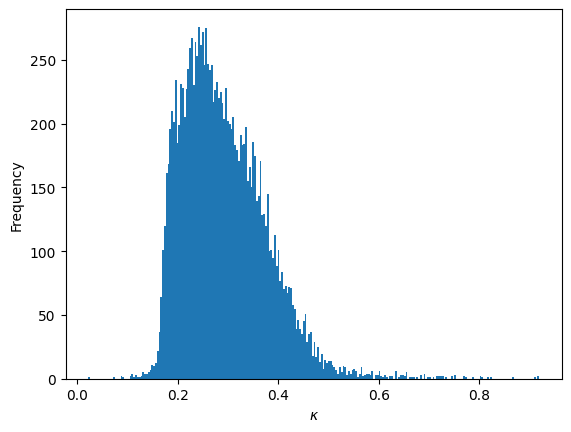

In [16]:
sub_m['k'].plot.hist(bins=250)
#plt.xlim([-1,1])
plt.xlabel('$\kappa$')
plt.savefig('./figures/k_hist.png', dpi=300)

In [17]:
sub_m['k'].median()

0.2790413442392051

In [18]:
sub_m[np.isfinite(sub_m['k'])]

,index,Time_Mid,SMPS_Bin02,SMPS_Bin03,SMPS_Bin04,SMPS_Bin05,SMPS_Bin06,SMPS_Bin07,SMPS_Bin08,SMPS_Bin09,...,Ice_Flag_2DS,total_mass,Org_vc,SO4_vc,NO3_vc,NH4_vc,Chl_vc,ams_tot_vc,k,D_c
0,0,2020-02-14 17:02:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.620,0.000902,0.000670,0.000399,0.000460,0.000005,0.002436,0.371129,76.125186
1,1,2020-02-14 17:03:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.685,0.001183,0.000804,0.000163,0.000440,0.000005,0.002595,0.339715,57.387727
2,2,2020-02-14 17:04:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3.427,0.000779,0.000894,0.000179,0.000430,-0.000005,0.002276,0.381408,69.531646
3,3,2020-02-14 17:05:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.922,0.000223,0.000555,0.000095,0.000323,-0.000010,0.001185,0.437961,47.125967
4,4,2020-02-14 17:06:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.641,0.000494,0.000667,0.000161,0.000362,0.000019,0.001702,0.400509,63.109374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14093,34020,2022-06-18 15:11:01.500,0.0,0.0,0.0,0.00,0.0,640.37,0.00,0.00,...,NaN,8.729,0.006852,0.000592,0.000190,0.000289,-0.000009,0.007915,0.189271,101.150533
14094,34021,2022-06-18 15:12:01.500,0.0,0.0,0.0,3172.65,0.0,635.06,0.00,685.19,...,NaN,8.273,0.006443,0.000525,0.000208,0.000285,0.000013,0.007474,0.190618,100.673455
14095,34022,2022-06-18 15:13:01.500,0.0,0.0,0.0,0.00,0.0,0.00,434.85,653.39,...,NaN,8.630,0.006588,0.000573,0.000223,0.000323,0.000028,0.007735,0.194419,99.356816
14096,34023,2022-06-18 15:14:01.500,0.0,0.0,0.0,0.00,0.0,591.20,0.00,0.00,...,NaN,9.038,0.007012,0.000602,0.000227,0.000303,0.000010,0.008154,0.191412,100.394680


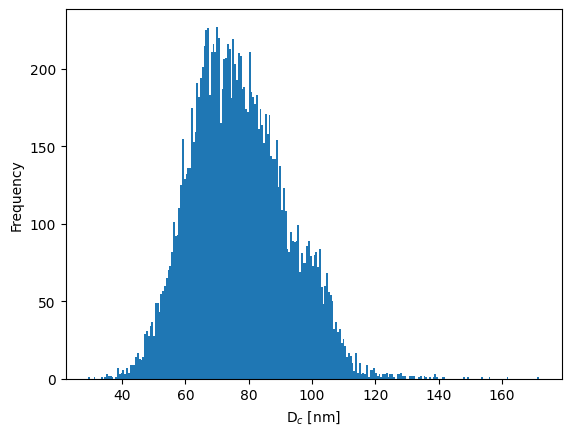

In [19]:
sub_m['D_c'].plot.hist(bins=250)
#plt.xlim([-1,1])
plt.xlabel('D$_c$ [nm]')
plt.savefig('./figures/Dc_hist.png', dpi=300)

In [20]:
sub_m['D_c'].median()

75.74605247959472

In [21]:
sub_m[np.isfinite(sub_m['D_c'])]

,index,Time_Mid,SMPS_Bin02,SMPS_Bin03,SMPS_Bin04,SMPS_Bin05,SMPS_Bin06,SMPS_Bin07,SMPS_Bin08,SMPS_Bin09,...,Ice_Flag_2DS,total_mass,Org_vc,SO4_vc,NO3_vc,NH4_vc,Chl_vc,ams_tot_vc,k,D_c
0,0,2020-02-14 17:02:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.620,0.000902,0.000670,0.000399,0.000460,0.000005,0.002436,0.371129,76.125186
1,1,2020-02-14 17:03:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.685,0.001183,0.000804,0.000163,0.000440,0.000005,0.002595,0.339715,57.387727
2,2,2020-02-14 17:04:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3.427,0.000779,0.000894,0.000179,0.000430,-0.000005,0.002276,0.381408,69.531646
3,3,2020-02-14 17:05:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.922,0.000223,0.000555,0.000095,0.000323,-0.000010,0.001185,0.437961,47.125967
4,4,2020-02-14 17:06:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.641,0.000494,0.000667,0.000161,0.000362,0.000019,0.001702,0.400509,63.109374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14093,34020,2022-06-18 15:11:01.500,0.0,0.0,0.0,0.00,0.0,640.37,0.00,0.00,...,NaN,8.729,0.006852,0.000592,0.000190,0.000289,-0.000009,0.007915,0.189271,101.150533
14094,34021,2022-06-18 15:12:01.500,0.0,0.0,0.0,3172.65,0.0,635.06,0.00,685.19,...,NaN,8.273,0.006443,0.000525,0.000208,0.000285,0.000013,0.007474,0.190618,100.673455
14095,34022,2022-06-18 15:13:01.500,0.0,0.0,0.0,0.00,0.0,0.00,434.85,653.39,...,NaN,8.630,0.006588,0.000573,0.000223,0.000323,0.000028,0.007735,0.194419,99.356816
14096,34023,2022-06-18 15:14:01.500,0.0,0.0,0.0,0.00,0.0,591.20,0.00,0.00,...,NaN,9.038,0.007012,0.000602,0.000227,0.000303,0.000010,0.008154,0.191412,100.394680


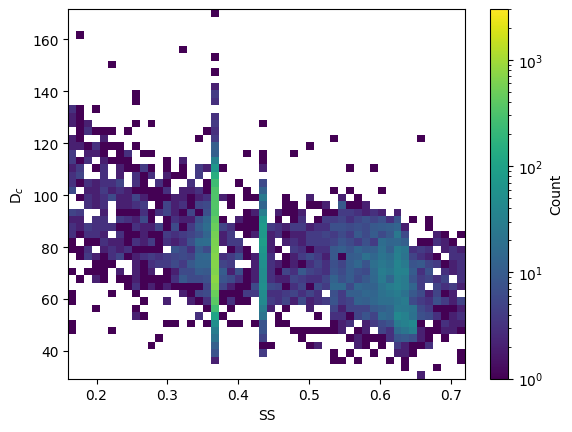

In [22]:
log_norm = mcolors.LogNorm(vmin=1, vmax=3000)

plt.hist2d(sub_m['CCN_SS'], sub_m['D_c'], bins=50, cmap='viridis', norm=log_norm)
plt.colorbar(label='Count', norm=log_norm)
plt.xlabel('SS')
plt.ylabel('D$_c$')
plt.savefig('./figures/D_c-SS.png', dpi=300)

In [23]:
bin_labels = ['SMPS_Bin02', 'SMPS_Bin03', 'SMPS_Bin04', 'SMPS_Bin05',
       'SMPS_Bin06', 'SMPS_Bin07', 'SMPS_Bin08', 'SMPS_Bin09', 'SMPS_Bin10',
       'SMPS_Bin11', 'SMPS_Bin12', 'SMPS_Bin13', 'SMPS_Bin14', 'SMPS_Bin15',
       'SMPS_Bin16', 'SMPS_Bin17', 'SMPS_Bin18', 'SMPS_Bin19', 'SMPS_Bin20',
       'SMPS_Bin21', 'SMPS_Bin22', 'SMPS_Bin23', 'SMPS_Bin24', 'SMPS_Bin25',
       'SMPS_Bin26', 'SMPS_Bin27', 'SMPS_Bin28', 'SMPS_Bin29', 'SMPS_Bin30', 'LAS_Bin01', 'LAS_Bin02', 'LAS_Bin03', 'LAS_Bin04', 'LAS_Bin05',
       'LAS_Bin06', 'LAS_Bin07', 'LAS_Bin08', 'LAS_Bin09', 'LAS_Bin10',
       'LAS_Bin11', 'LAS_Bin12', 'LAS_Bin13', 'LAS_Bin14', 'LAS_Bin15',
       'LAS_Bin16', 'LAS_Bin17', 'LAS_Bin18', 'LAS_Bin19', 'LAS_Bin20',
       'LAS_Bin21', 'LAS_Bin22', 'LAS_Bin23', 'LAS_Bin24', 'LAS_Bin25',
       'LAS_Bin26']

lower_bounds = [3.36, 3.76, 4.22, 4.74, 5.32, 5.97, 6.69, 7.51, 8.43, 9.46, 10.6, 11.9, 13.4, 15.0, 16.8, 18.9, 21.2, 23.8, 26.7, 29.9, 33.6, 37.6, 42.2, 47.4, 53.2, 59.7, 66.9, 75.1, 84.3, 93.9, 106.1, 119.0, 133.6, 149.9, 168.2, 188.7, 211.7, 237.5, 266.5, 299.0, 335.5, 376.5, 422.4, 473.9, 531.8, 596.6, 669.5, 751.1, 842.8, 945.6, 1129.5, 1421.9, 1790.1, 2253.6, 2837.1]
upper_bounds = [3.76, 4.22, 4.74, 5.32, 5.97, 6.69, 7.51, 8.43, 9.46, 10.6, 11.9, 13.4, 15.0, 16.8, 18.9, 21.2, 23.8, 26.7, 29.9, 33.6, 37.6, 42.2, 47.4, 53.2, 59.7, 66.9, 75.1, 84.3, 94.0, 106.1, 119.0, 133.6, 149.9, 168.2, 188.7, 211.7, 237.5, 266.5, 299.0, 335.5, 376.5, 422.4, 473.9, 531.8, 596.6, 669.5, 751.1, 842.8, 945.6, 1129.5, 1421.9, 1790.1, 2253.6, 2837.1, 3487.5]

dlogd=[]
for i in range(0,len(lower_bounds)):
       dlogd.append(np.log(upper_bounds[i]) - np.log(lower_bounds[i]))

In [24]:
dlogd

[0.11247798342669024,
 0.11541617064611742,
 0.11620200765906463,
 0.11543616764656806,
 0.11527362405095753,
 0.11386694673562636,
 0.11562159163590646,
 0.11556130623772054,
 0.11527561105002304,
 0.11378161805423437,
 0.11568439899946226,
 0.11871630683938195,
 0.1127954941453444,
 0.11332868530700324,
 0.11778303565638337,
 0.11483925961237018,
 0.11568439899946226,
 0.11497798472877463,
 0.11319491499043677,
 0.11666758657251819,
 0.11247798342669002,
 0.11541617064611742,
 0.11620200765906485,
 0.11543616764656761,
 0.11527362405095776,
 0.11386694673562658,
 0.11562159163590646,
 0.1155613062377201,
 0.10891291726219432,
 0.12215165940571993,
 0.11474144749159265,
 0.11572676799101611,
 0.11511814400600606,
 0.11518534243029599,
 0.11500470483565639,
 0.11501172576631546,
 0.11499744533387624,
 0.11520662013120297,
 0.11506932978478801,
 0.11517838302104977,
 0.11529609082821146,
 0.11503468515210358,
 0.11504359658149088,
 0.1152711498353769,
 0.1149793932717289,
 0.11528429305

In [25]:
sub_m2 = sub_m.copy()
sub_m2['CCN_n_pred'] = np.nan
bl_length = len(bin_labels)
#bin_pres_frac = []
for i in tqdm(range(0, len(sub_m2))):
    row = sub_m2.iloc[i]
    d_c = row['D_c']

    for j, ub in enumerate(upper_bounds):
        #print(lb)
        if d_c < ub:
            break
    
    bin_frac = (upper_bounds[j] - d_c) / (upper_bounds[j] - lower_bounds[j])

    count = 0
    if np.isfinite(row[bin_labels[j]]*bin_frac):
        sub_m2.loc[i, 'CCN_n_pred'] = row[bin_labels[j]]*bin_frac*dlogd[j]
        count+=1
    else:
        sub_m2.loc[i, 'CCN_n_pred'] = 0
    for k in range(j+1, bl_length):
        if np.isfinite(row[bin_labels[k]]):
            sub_m2.loc[i, 'CCN_n_pred'] += row[bin_labels[k]]*dlogd[k]
            count += 1
    if count/(bl_length-j) < .9:
        sub_m2.loc[i, 'CCN_n_pred'] = np.nan
    #bin_pres_frac.append(count/(bl_length-j))
sub_m2_og = sub_m2.copy()

100%|██████████| 14098/14098 [00:12<00:00, 1134.40it/s]


In [26]:
sub_m2 = sub_m2[np.isfinite(sub_m2['CCN_n_pred'])]
sub_m2 = sub_m2[sub_m2['N_CCN_stdPT']>0]

In [27]:
sub_m2_og.keys()

Index(['index', 'Time_Mid', 'SMPS_Bin02', 'SMPS_Bin03', 'SMPS_Bin04',
       'SMPS_Bin05', 'SMPS_Bin06', 'SMPS_Bin07', 'SMPS_Bin08', 'SMPS_Bin09',
       'SMPS_Bin10', 'SMPS_Bin11', 'SMPS_Bin12', 'SMPS_Bin13', 'SMPS_Bin14',
       'SMPS_Bin15', 'SMPS_Bin16', 'SMPS_Bin17', 'SMPS_Bin18', 'SMPS_Bin19',
       'SMPS_Bin20', 'SMPS_Bin21', 'SMPS_Bin22', 'SMPS_Bin23', 'SMPS_Bin24',
       'SMPS_Bin25', 'SMPS_Bin26', 'SMPS_Bin27', 'SMPS_Bin28', 'SMPS_Bin29',
       'SMPS_Bin30', 'leg', 'Org_Ave_IsoK_STP', 'SO4_Ave_IsoK_STP',
       'NO3_Ave_IsoK_STP', 'NH4_Ave_IsoK_STP', 'Chl_Ave_IsoK_STP',
       'mz42_Ave_IsoK_STP', 'mz43_Ave_IsoK_STP', 'mz44_Ave_IsoK_STP',
       'mz55_Ave_IsoK_STP', 'mz57_Ave_IsoK_STP', 'mz58_Ave_IsoK_STP',
       'mz60_Ave_IsoK_STP', 'mz79_Ave_IsoK_STP', 'mz91_Ave_IsoK_STP', 'CCN_SS',
       'N_CCN_stdPT', 'LAS_Bin01', 'LAS_Bin02', 'LAS_Bin03', 'LAS_Bin04',
       'LAS_Bin05', 'LAS_Bin06', 'LAS_Bin07', 'LAS_Bin08', 'LAS_Bin09',
       'LAS_Bin10', 'LAS_Bin11', 'LAS_Bin12'

In [28]:
#sub_m2_og = sub_m2.copy()
#sub_m2 = sub_m2_og[(sub_m2_og['CCN_n_pred']>10) & (sub_m2_og['N_CCN_stdPT']>30)]

In [29]:
sub_m2[np.logical_not(sub_m2['CCN_n_pred'].isna())]

,index,Time_Mid,SMPS_Bin02,SMPS_Bin03,SMPS_Bin04,SMPS_Bin05,SMPS_Bin06,SMPS_Bin07,SMPS_Bin08,SMPS_Bin09,...,total_mass,Org_vc,SO4_vc,NO3_vc,NH4_vc,Chl_vc,ams_tot_vc,k,D_c,CCN_n_pred
0,0,2020-02-14 17:02:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.620,0.000902,0.000670,0.000399,0.000460,0.000005,0.002436,0.371129,76.125186,1003.246080
12,19,2020-02-14 17:21:30.500,0.0,0.0,0.0,0.00,0.0,626.43,0.00,470.47,...,6.062,0.001133,0.000721,0.001232,0.000789,0.000034,0.003909,0.400640,56.670757,1652.600667
14,22,2020-02-14 17:24:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.042,0.001114,0.000725,0.001210,0.000799,0.000040,0.003889,0.401862,77.004867,1219.717695
17,33,2020-02-14 17:35:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.665,0.000910,0.000588,0.000653,0.000808,0.000058,0.003017,0.396316,79.920672,1188.662207
18,35,2020-02-14 17:37:30.500,0.0,0.0,0.0,0.00,0.0,0.00,370.45,0.00,...,3.235,0.000859,0.000643,0.000336,0.000336,0.000022,0.002196,0.363440,76.094474,1622.601749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14093,34020,2022-06-18 15:11:01.500,0.0,0.0,0.0,0.00,0.0,640.37,0.00,0.00,...,8.729,0.006852,0.000592,0.000190,0.000289,-0.000009,0.007915,0.189271,101.150533,3711.133408
14094,34021,2022-06-18 15:12:01.500,0.0,0.0,0.0,3172.65,0.0,635.06,0.00,685.19,...,8.273,0.006443,0.000525,0.000208,0.000285,0.000013,0.007474,0.190618,100.673455,3080.051429
14095,34022,2022-06-18 15:13:01.500,0.0,0.0,0.0,0.00,0.0,0.00,434.85,653.39,...,8.630,0.006588,0.000573,0.000223,0.000323,0.000028,0.007735,0.194419,99.356816,3542.326842
14096,34023,2022-06-18 15:14:01.500,0.0,0.0,0.0,0.00,0.0,591.20,0.00,0.00,...,9.038,0.007012,0.000602,0.000227,0.000303,0.000010,0.008154,0.191412,100.394680,3131.155645


In [30]:
sub_m.keys()

Index(['index', 'Time_Mid', 'SMPS_Bin02', 'SMPS_Bin03', 'SMPS_Bin04',
       'SMPS_Bin05', 'SMPS_Bin06', 'SMPS_Bin07', 'SMPS_Bin08', 'SMPS_Bin09',
       'SMPS_Bin10', 'SMPS_Bin11', 'SMPS_Bin12', 'SMPS_Bin13', 'SMPS_Bin14',
       'SMPS_Bin15', 'SMPS_Bin16', 'SMPS_Bin17', 'SMPS_Bin18', 'SMPS_Bin19',
       'SMPS_Bin20', 'SMPS_Bin21', 'SMPS_Bin22', 'SMPS_Bin23', 'SMPS_Bin24',
       'SMPS_Bin25', 'SMPS_Bin26', 'SMPS_Bin27', 'SMPS_Bin28', 'SMPS_Bin29',
       'SMPS_Bin30', 'leg', 'Org_Ave_IsoK_STP', 'SO4_Ave_IsoK_STP',
       'NO3_Ave_IsoK_STP', 'NH4_Ave_IsoK_STP', 'Chl_Ave_IsoK_STP',
       'mz42_Ave_IsoK_STP', 'mz43_Ave_IsoK_STP', 'mz44_Ave_IsoK_STP',
       'mz55_Ave_IsoK_STP', 'mz57_Ave_IsoK_STP', 'mz58_Ave_IsoK_STP',
       'mz60_Ave_IsoK_STP', 'mz79_Ave_IsoK_STP', 'mz91_Ave_IsoK_STP', 'CCN_SS',
       'N_CCN_stdPT', 'LAS_Bin01', 'LAS_Bin02', 'LAS_Bin03', 'LAS_Bin04',
       'LAS_Bin05', 'LAS_Bin06', 'LAS_Bin07', 'LAS_Bin08', 'LAS_Bin09',
       'LAS_Bin10', 'LAS_Bin11', 'LAS_Bin12'

In [31]:
# plt.hist2d(sub_m2['N_CCN_stdPT'], sub_m2['CCN_n_pred'], bins=10000, cmap='bone_r', linewidths=0)
# plt.colorbar(label='count in bin')
# plt.plot(xy, xy, c='r', ls='--')
# plt.xlim([0,2000])
# plt.ylim([0,4000])
# plt.xlabel('N_CCN_stdPT')
# plt.ylabel('CCN_n_pred')
# plt.show()

Text(0.5, 0, 'Measured CCN [cm$^{-3}$]')

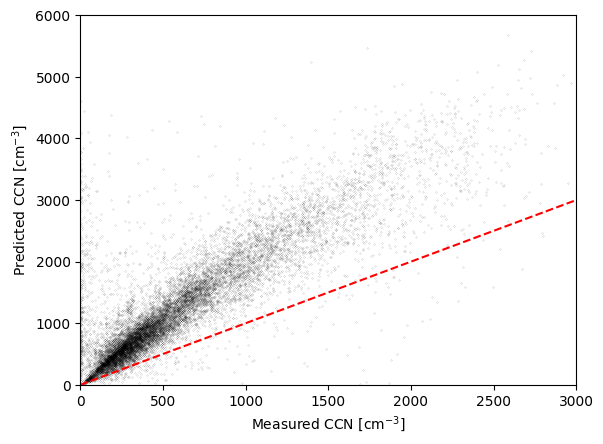

In [32]:
plt.scatter(sub_m2['N_CCN_stdPT'], sub_m2['CCN_n_pred'], s=.005, c='black')
xy = np.linspace(0,10000)
plt.plot(xy, xy, c='r', ls='--')
plt.xlim([0,3000])
plt.ylim([0,6000])
plt.ylabel('Predicted CCN [cm$^{-3}$]')
plt.xlabel('Measured CCN [cm$^{-3}$]')

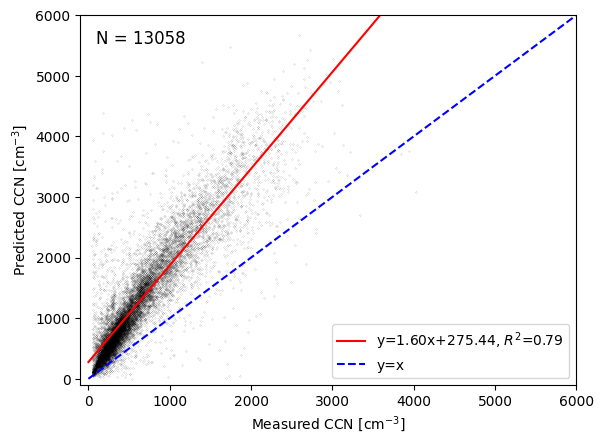

In [33]:
# Define the data
sub_m3 = sub_m2[sub_m2['N_CCN_stdPT']>50]
x = sub_m3['N_CCN_stdPT']
y = sub_m3['CCN_n_pred']
mask = ~np.isnan(x) & ~np.isnan(y)
num_points = np.sum(mask)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the line of best fit
fit_line = slope * np.linspace(0, x.max()) + intercept

# Plot the data and best fit line
plt.scatter(x, y, s=0.005, c='black')
plt.plot(np.linspace(0, x.max()), fit_line, c='r', label=f'y={slope:.2f}x+{intercept:.2f}, $R^2$={r_value**2:.2f}')
plt.plot(np.linspace(0, 6000), np.linspace(0, 6000), c='b', ls='--', label='y=x')
plt.xlim([-100, 6000])
plt.ylim([-100, 6000])
plt.ylabel('Predicted CCN [cm$^{-3}$]')
plt.xlabel('Measured CCN [cm$^{-3}$]')

plt.text(0.15, 0.85, f"N = {num_points}",
         fontsize=12, transform=plt.gcf().transFigure,
         verticalalignment='top', horizontalalignment='left')

plt.legend(loc='lower right')
plt.savefig('./figures/closure1.png', dpi=300)

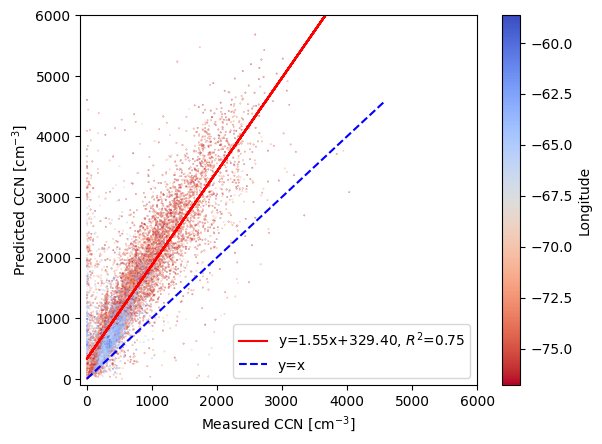

In [34]:
# Define the data
x = sub_m2['N_CCN_stdPT']
y = sub_m2['CCN_n_pred']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the line of best fit
fit_line = slope * x + intercept

# Plot the data and best fit line
plt.scatter(x, y, s=0.05, c=sub_m2['Longitude'], cmap='coolwarm_r', alpha=1)
plt.plot(x, fit_line, c='r', label=f'y={slope:.2f}x+{intercept:.2f}, $R^2$={r_value**2:.2f}')
plt.plot(np.linspace(0, x.max()), np.linspace(0, x.max()), c='b', ls='--', label='y=x')
plt.xlim([-100, 6000])
plt.ylim([-100, 6000])
plt.ylabel('Predicted CCN [cm$^{-3}$]')
plt.xlabel('Measured CCN [cm$^{-3}$]')
plt.legend()
plt.colorbar(label='Longitude')
#plt.savefig('./figures/closure1.png', dpi=300)

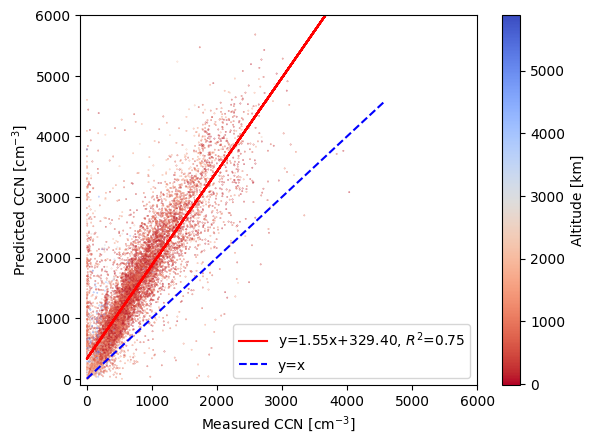

In [35]:
# Define the data
x = sub_m2['N_CCN_stdPT']
y = sub_m2['CCN_n_pred']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the line of best fit
fit_line = slope * x + intercept

# Plot the data and best fit line
plt.scatter(x, y, s=0.05, c=sub_m2['GPS_altitude'], cmap='coolwarm_r', alpha=1)
plt.plot(x, fit_line, c='r', label=f'y={slope:.2f}x+{intercept:.2f}, $R^2$={r_value**2:.2f}')
plt.plot(np.linspace(0, x.max()), np.linspace(0, x.max()), c='b', ls='--', label='y=x')
plt.xlim([-100, 6000])
plt.ylim([-100, 6000])
plt.ylabel('Predicted CCN [cm$^{-3}$]')
plt.xlabel('Measured CCN [cm$^{-3}$]')
plt.legend()
plt.colorbar(label='Altitude [km]')
#plt.savefig('./figures/closure1.png', dpi=300)

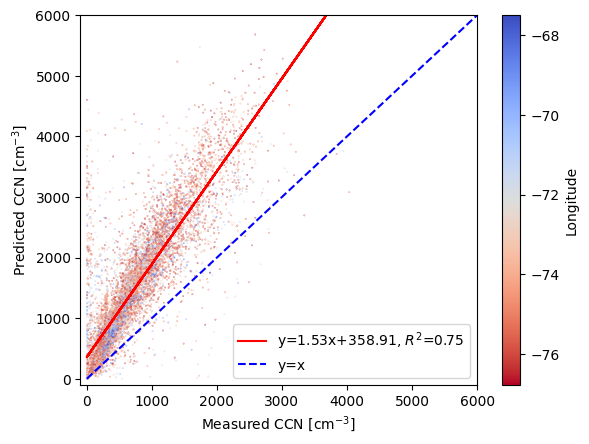

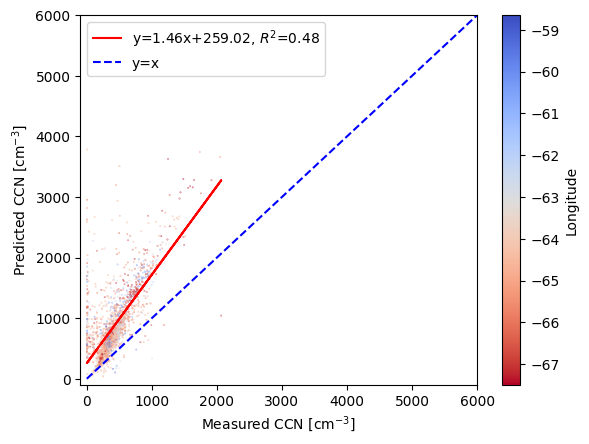

In [36]:
# Define the data
x = sub_m2[sub_m2['Longitude']<=-67.5]['N_CCN_stdPT']
y = sub_m2[sub_m2['Longitude']<=-67.5]['CCN_n_pred']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the line of best fit
fit_line = slope * x + intercept

# Plot the data and best fit line
plt.scatter(x, y, s=0.05, c=sub_m2[sub_m2['Longitude']<=-67.5]['Longitude'], cmap='coolwarm_r', alpha=1)
plt.plot(x, fit_line, c='r', label=f'y={slope:.2f}x+{intercept:.2f}, $R^2$={r_value**2:.2f}')
plt.plot(np.linspace(0, 6000), np.linspace(0, 6000), c='b', ls='--', label='y=x')
plt.xlim([-100, 6000])
plt.ylim([-100, 6000])
plt.ylabel('Predicted CCN [cm$^{-3}$]')
plt.xlabel('Measured CCN [cm$^{-3}$]')
plt.legend()
plt.colorbar(label='Longitude') 
plt.show()


# Define the data
x = sub_m2[sub_m2['Longitude']>-67.5]['N_CCN_stdPT']
y = sub_m2[sub_m2['Longitude']>-67.5]['CCN_n_pred']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the line of best fit
fit_line = slope * x + intercept

# Plot the data and best fit line
plt.scatter(x, y, s=0.05, c=sub_m2[sub_m2['Longitude']>-67.5]['Longitude'], cmap='coolwarm_r', alpha=1)
plt.plot(x, fit_line, c='r', label=f'y={slope:.2f}x+{intercept:.2f}, $R^2$={r_value**2:.2f}')
plt.plot(np.linspace(0, 6000), np.linspace(0, 6000), c='b', ls='--', label='y=x')
plt.xlim([-100, 6000])
plt.ylim([-100, 6000])
plt.ylabel('Predicted CCN [cm$^{-3}$]')
plt.xlabel('Measured CCN [cm$^{-3}$]')
plt.legend()
plt.colorbar(label='Longitude') 
plt.show()

#plt.savefig('./figures/closure_lat_split.png', dpi=300)

In [186]:
d_group = sub_m3

In [187]:
d_group.groupby('leg').median().index

/var/folders/tf/wjndf74j55q6hwwhxhpzl0100000gn/T/ipykernel_29579/2570429796.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d_group.groupby('leg').median().index


Index(['ABL', 'ACB', 'ACT', 'Ascent', 'BBL', 'BCB', 'BCT', 'Descent', 'MinAlt',
       'Other', 'Remote Sensing (HSRL-2)', 'Slant/Spiral', 'Takeoff/Landing',
       'Transit'],
      dtype='object', name='leg')

In [188]:
d_group

,index,Time_Mid,SMPS_Bin02,SMPS_Bin03,SMPS_Bin04,SMPS_Bin05,SMPS_Bin06,SMPS_Bin07,SMPS_Bin08,SMPS_Bin09,...,total_mass,Org_vc,SO4_vc,NO3_vc,NH4_vc,Chl_vc,ams_tot_vc,k,D_c,CCN_n_pred
0,0,2020-02-14 17:02:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.620,0.000902,0.000670,0.000399,0.000460,0.000005,0.002436,0.371129,76.125186,1003.246080
12,19,2020-02-14 17:21:30.500,0.0,0.0,0.0,0.00,0.0,626.43,0.00,470.47,...,6.062,0.001133,0.000721,0.001232,0.000789,0.000034,0.003909,0.400640,56.670757,1652.600667
14,22,2020-02-14 17:24:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.042,0.001114,0.000725,0.001210,0.000799,0.000040,0.003889,0.401862,77.004867,1219.717695
17,33,2020-02-14 17:35:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.665,0.000910,0.000588,0.000653,0.000808,0.000058,0.003017,0.396316,79.920672,1188.662207
18,35,2020-02-14 17:37:30.500,0.0,0.0,0.0,0.00,0.0,0.00,370.45,0.00,...,3.235,0.000859,0.000643,0.000336,0.000336,0.000022,0.002196,0.363440,76.094474,1622.601749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14093,34020,2022-06-18 15:11:01.500,0.0,0.0,0.0,0.00,0.0,640.37,0.00,0.00,...,8.729,0.006852,0.000592,0.000190,0.000289,-0.000009,0.007915,0.189271,101.150533,3711.133408
14094,34021,2022-06-18 15:12:01.500,0.0,0.0,0.0,3172.65,0.0,635.06,0.00,685.19,...,8.273,0.006443,0.000525,0.000208,0.000285,0.000013,0.007474,0.190618,100.673455,3080.051429
14095,34022,2022-06-18 15:13:01.500,0.0,0.0,0.0,0.00,0.0,0.00,434.85,653.39,...,8.630,0.006588,0.000573,0.000223,0.000323,0.000028,0.007735,0.194419,99.356816,3542.326842
14096,34023,2022-06-18 15:14:01.500,0.0,0.0,0.0,0.00,0.0,591.20,0.00,0.00,...,9.038,0.007012,0.000602,0.000227,0.000303,0.000010,0.008154,0.191412,100.394680,3131.155645


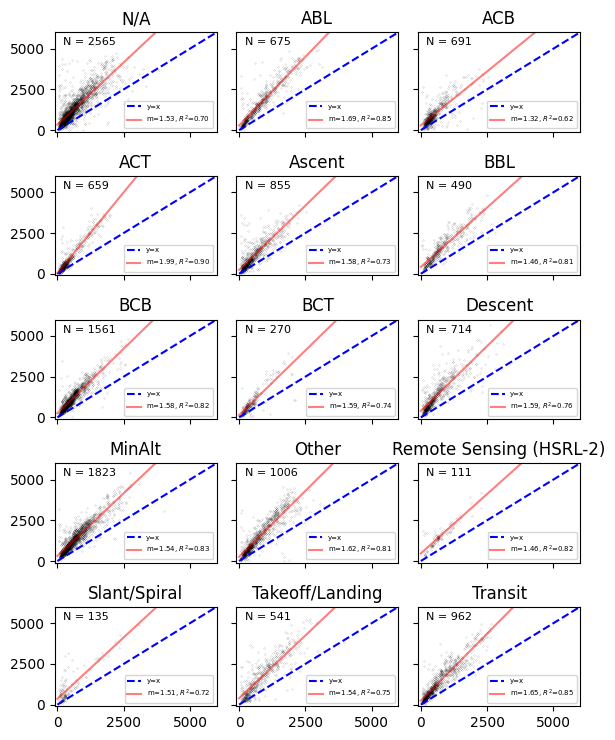

In [189]:
fig, axes = plt.subplots(5,3,figsize=(6, 7.5), sharex='all', sharey='all')
leg_labels = ['0', 'ABL', 'ACB', 'ACT', 'Ascent', 'BBL', 'BCB', 'BCT', 'Descent',
       'MinAlt', 'Other', 'Remote Sensing (HSRL-2)', 'Slant/Spiral',
       'Takeoff/Landing', 'Transit']
for i, ax in enumerate(axes.flatten()):
    if leg_labels[i] == '0':
        d_i = d_group[d_group['leg'].isna()]
    else:
        d_i = d_group[d_group['leg'] == leg_labels[i]]
    ax.scatter(d_i['N_CCN_stdPT'], d_i['CCN_n_pred'], s=0.005, c='black')
    ax.set_title(leg_labels[i])
    ax.plot(np.linspace(0, 6000), np.linspace(0, 6000), c='b', ls='--', label='y=x')

    slope, intercept, r_value, p_value, std_err = linregress(d_i['N_CCN_stdPT'], d_i['CCN_n_pred'])
    # Calculate the line of best fit
    fit_line = slope * np.linspace(0, 6000) + intercept
    ax.plot(np.linspace(0, 6000), fit_line, c='r', label=f'm={slope:.2f}, $R^2$={r_value**2:.2f}', alpha=.5)
    ax.legend(fontsize=5, loc='lower right')
    mask = ~np.isnan(d_i['N_CCN_stdPT']) & ~np.isnan(d_i['CCN_n_pred'])
    num_points = np.sum(mask)
    ax.text(0.05, 0.95, f"N = {num_points}",
         fontsize=8, transform=ax.transAxes,
         verticalalignment='top', horizontalalignment='left')

axes[0,0].set_title('N/A')
axes[0,0].set_xlim([-100, 6000])
axes[0,0].set_ylim([-100, 6000])
fig.tight_layout()
plt.savefig('./figures/all_legs.png', dpi=300, bbox_inches='tight')

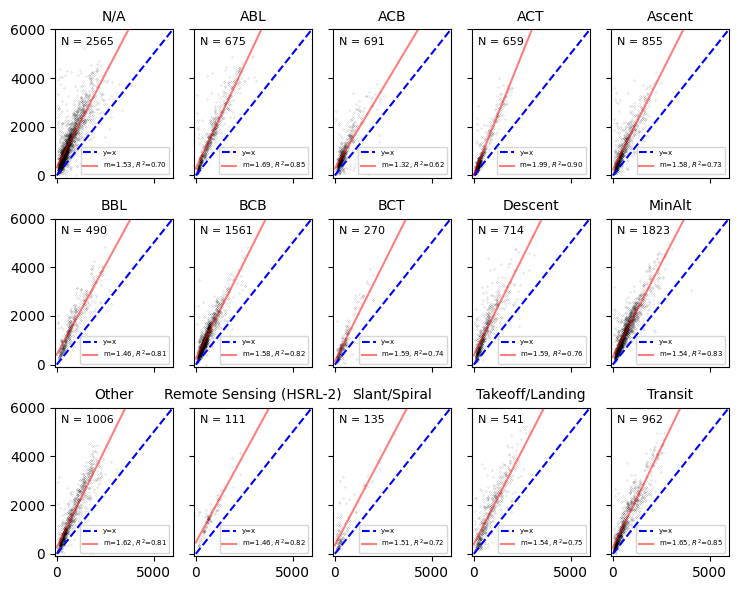

In [190]:
fig, axes = plt.subplots(3,5,figsize=(7.5, 6), sharex='all', sharey='all')
leg_labels = ['0', 'ABL', 'ACB', 'ACT', 'Ascent', 'BBL', 'BCB', 'BCT', 'Descent',
       'MinAlt', 'Other', 'Remote Sensing (HSRL-2)', 'Slant/Spiral',
       'Takeoff/Landing', 'Transit']
for i, ax in enumerate(axes.flatten()):
    if leg_labels[i] == '0':
        d_i = d_group[d_group['leg'].isna()]
    else:
        d_i = d_group[d_group['leg'] == leg_labels[i]]
    ax.scatter(d_i['N_CCN_stdPT'], d_i['CCN_n_pred'], s=0.005, c='black')
    ax.set_title(leg_labels[i], fontsize=10)
    ax.plot(np.linspace(0, 6000), np.linspace(0, 6000), c='b', ls='--', label='y=x')

    slope, intercept, r_value, p_value, std_err = linregress(d_i['N_CCN_stdPT'], d_i['CCN_n_pred'])
    # Calculate the line of best fit
    fit_line = slope * np.linspace(0, 6000) + intercept
    ax.plot(np.linspace(0, 6000), fit_line, c='r', label=f'm={slope:.2f}, $R^2$={r_value**2:.2f}', alpha=.5)
    ax.legend(fontsize=5, loc='lower right')
    mask = ~np.isnan(d_i['N_CCN_stdPT']) & ~np.isnan(d_i['CCN_n_pred'])
    num_points = np.sum(mask)
    ax.text(0.05, 0.95, f"N = {num_points}",
         fontsize=8, transform=ax.transAxes,
         verticalalignment='top', horizontalalignment='left')

axes[0,0].set_title('N/A', fontsize=10)
axes[0,0].set_xlim([-100, 6000])
axes[0,0].set_ylim([-100, 6000])
fig.tight_layout()
plt.savefig('./figures/all_legs_hor.png', dpi=300, bbox_inches='tight')